![Titlepic](Images/mazak-integrex-200y.jpeg)

# Introduction


This paper describes how to derive the kinematic model for a Mazak Integrex 200y (5-axis turning and milling) with Tool B rotation, work side C rotation and a virtual Y axis of the slanted bed.

In [1]:
from IPython.display import display, Image

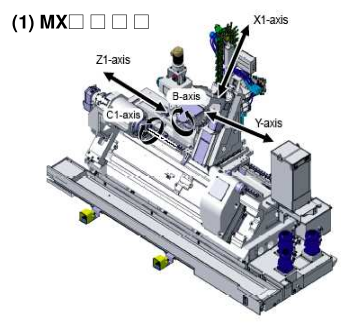

In [2]:
display(Image(filename="Images/machine_diagram.png",
              height=500, width=500))

In [3]:

# only used to display equations out of code blocks
from IPython.display import Math, display

# joint position vector P 
var('Px','Py','Pz')
P_=matrix([[Px],
           [Py],
           [Pz],
           [1]])

# cartesian position vector Q
var('Qx','Qy','Qz')
Q_=matrix([[Qx],
           [Qy],
           [Qz],
           [1]])

A custom kinematic model in LinuxCNC is used to calculate cartesian coordinates from given machine joint positions (forward kinematics) and also to calculate the required machine joint positions to reach a given coordinate position (inverse kinematics). In the following description we will use vectors as mathematical representations of the two positions: 


\begin{equation}
Q ~=~
\left(\begin{array}{rrrr}
  Qx \\
  Qy \\
  Qz \\
  1
\end{array}\right)
~
Cartesian~position
~~~~~~~~~~~~
P ~=~
\left(\begin{array}{rrrr}
  Px \\
  Py \\
  Pz \\
  1
\end{array}\right)
~
Joint~position
\end{equation}

Note that the fourth row is added to be able to multiply the vectors with a 4x4 transformation matrix. 

# Virtual Y axis
To be able to move the tool in a cartesian XYZ coordinate system the machine has a linear joint (Ys in the diagram above). Note that this joint is not perpendicular to the X axis/joint so we need to compensate this in the kinematic. 



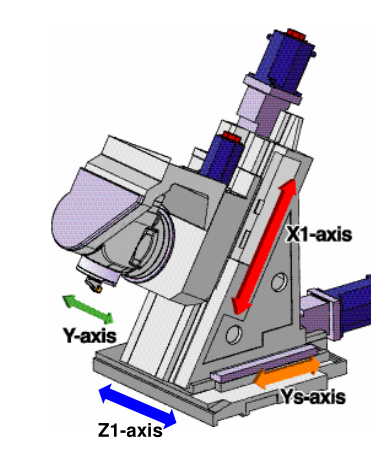

In [4]:
display(Image(filename="Images/composite_y_axis.png",
              height=500, width=500))

In [5]:
# define forward transformation matrix for virtual axis Y 
var('Cy','Sy')
Ty=matrix([[  1, -Cy,   0, 0],
           [  0,  Sy,   0, 0],
           [  0,   0,   1, 0],
           [  0,   0,   0, 1]])
display(Math(rf'T_y =~'+latex(Ty)))

<IPython.core.display.Math object>

with $~~Sy = sin(\theta_y),~~~ Cy = cos(\theta_y)$
and $\theta_y$ being the angle between the direction of the X slide and the horizontal joint (Ys in the diagram).

In [6]:
# calculate forward kinematic
Q_out=Ty*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(Ty)+rf'\cdot'+latex(P_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

In [7]:
# define inverse transformation matrix for virtual axis Y 
var('Cy','Sy')
Tiy=matrix([[  1,  1/(Sy/Cy), 0, 0],
           [  0,    1/Sy,    0, 0],
           [  0,     0,      1, 0],
           [  0,     0,      0, 1]])
display(Math(rf'T_iy =~'+latex(Tiy)))

<IPython.core.display.Math object>

Note that $~~{Sy\over{Cy}} = {1\over{tan(\theta_y)}}$

In [8]:
# calculate inverse kinematic
P_out=Tiy*Q_
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(Tiy)+rf'\cdot'+latex(Q_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

# TCP Kinematic model
For the tool to follow a point on the work piece we need a model that calculates where a given position on the work piece moves to when the rotary joints are rotated. In our example configuration the work piece will be mounted on the C rotary table and it is therefore here where we start to build our forward kinematic model.<br>
Note that in matrix multiplication the order is important that is $A\cdot B$ is generally not equal to $B \cdot A$. 





## Work-Side Rotary C
### Forward transformation

We start with the basic rotation around the C axis. In this case our forward transformation matrix $^QA_P$ is equal to a rotation around the z-axis:

\begin{equation}
 ^QA_P=~ R_w 
\end{equation}



In [9]:
# define rotation matrix for axis C (ie rotation around z-axis)
var('Cw','Sw')
Rw=matrix([[ Cw, -Sw,   0, 0],
           [ Sw,  Cw,   0, 0],
           [ 0 ,  0 ,   1, 0],
           [ 0,   0 ,   0, 1]])
display(Math(rf'R_w =~'+latex(Rw)))

<IPython.core.display.Math object>

with $~~Sw = sin(\theta_w),~~~ Cw = cos(\theta_w)$
and $\theta_w$ being the angle of rotation of joint C

To derive the coordinate position $Q(Qx,Qy,Qz)$ we now need to multiply the joint position vector $P(Px,Py,Pz)$ with our forward transformation matrix $^QA_P$. <br>
Note that the input values $P$ to our model need to be on the right hand side of the matrix multiplication.

$$ Q=~^QA_P \cdot P $$

In [10]:
# calculate forward kinematic
Q_out=Rw*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(Rw)+rf'\cdot'+latex(P_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

In [11]:
# calculate inverse kinematic
P_out=Rw.transpose()*Q_
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(Rw.transpose())+rf'\cdot'+latex(Q_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>


## Rotary B
### Forward transformation

Because the linear (x,y,z)-axis motion or tool-translation $P(Px, Py, Pz)$ happens between the table rotation C and the spindle rotation B we need to insert that tool-translation as a tranformation matrix in between the rotation C and the rotation B.

To add the B rotation we expand $~^QA_P$ by multiplying first the tool-translation $T_p$ from the right and then the rotation matrix $R_b$ also from the right: 

\begin{equation}
 ^QA_P=~ R_c \cdot T_p \cdot R_b
\end{equation}

Note how the transformation matrix $~^QA_P$ is constructed from left to right. The first operation is on the left and the last operation is on the right as we work our way from the work side to the spindle side of the kinematic chain.

In [12]:
# define joint position matrix
var('Px','Py','Pz')
Tp=matrix([[ 1, 0, 0, Px ],
           [ 0, 1, 0, Py],
           [ 0, 0, 1, Pz],
           [ 0, 0, 0, 1 ]])

#define rotation matrix for tool rotation (joint B)
var('Ct','St')
Rt=matrix([[Ct,  0,  St,  0],
           [ 0,  1,   0,  0],
           [-St,  0,  Ct, 0],
           [ 0,  0,   0, 1]])

display(Math(rf'T_p =~'+latex(Tp)+'~~'+rf'R_t =~'+latex(Rt)))

<IPython.core.display.Math object>

with $~~St = sin(\theta_t),~~~ Ct = cos(\theta_t)$
and $\theta_t$ being the angle of rotation of joint B 

In [13]:
# calculate the forward transformation matrix
qAp=Rw*Tp*Rt
display(Math(rf'^QA_P =~~'+latex(Rw)+rf'\cdot'+latex(Tp)+rf'\cdot'+latex(Rt)))
display(Math(rf'^QA_P =~~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note that the tool-position (ie the vector in the 4th column of our transformation matrix $^QA_P$) does not contain the B-rotation in any form. Only the tool-orientation (ie columns 1,2 and 3) is influenced by the addition of the rotation B. This may seem wrong but we have to remember that after the B-rotation ($Rb$) we have not yet built any offset (tool-length or pivot-length) into our model (ie there is no translation matrix on the right side of $Rb$). Hence for now a rotation around B simply means that a tool of lenght zero (ie a point) rotates with joint B and does not change it's position. So in the current form it is really not very interesting to test the effect of the added rotation around B so we will move on along the kinematic chain and add the geometric offsets ($D_x,D_z$) , the rotation A ($R_a$) and the pivot-lengths ($Ly,Lz$) to arrive at the spindle nose.

In [14]:
# define coordinate position matrix
var('Qx','Qy','Qz')
Tq=matrix([[ 1, 0, 0, Qx ],
           [ 0, 1, 0, Qy],
           [ 0, 0, 1, Qz],
           [ 0, 0, 0, 1 ]])
display(Math(rf'T_q =~'+latex(Tq)))

<IPython.core.display.Math object>

In [15]:
# calculate the inverse transformation matrix
#pAq=Rw*Tp*Rt
pAq=Rw.transpose()*Tq*Rw*Rt
display(Math(rf'^PA_Q =~~'+latex(pAq)))

<IPython.core.display.Math object>

## A closer look at the spindle rotary assembly

To get a better understanding of these offsets in the spindle rotary assembly of our example machine we need to have a look at how the rotary axes A and B are arranged in the spindle body.
This shows our spindle assembly in its home position ($\theta_a =0$, $\theta_b=0$). To get a clearer idea of the situation a tool (purple cylinder) is shown protruding from the spindle nose.


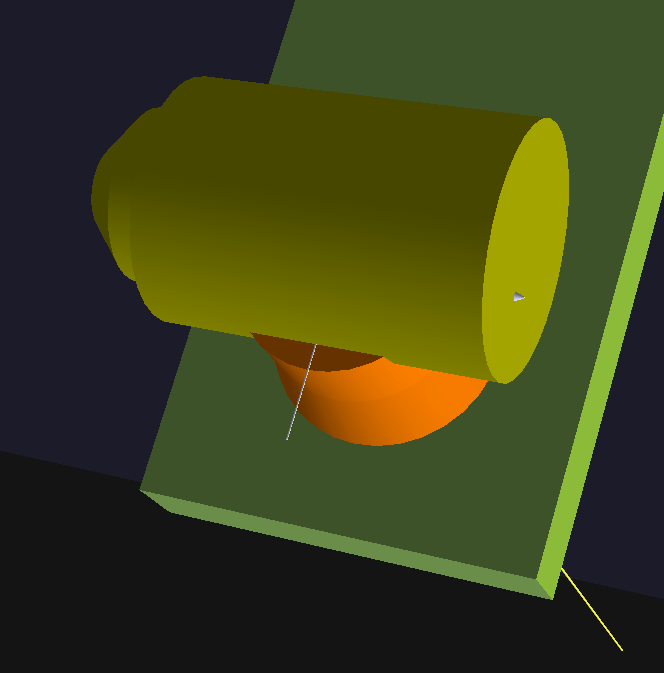

In [16]:
display(Image(filename="Images/tool_rotary_assembly.png",
              height=300, width=300))

## Pivot-point, pivot-length and offset of the tool rotary assembly
Because the rotational offsets in question are all hidden inside the spindle body we simplify the model to the relevant kinematic components. The white cross with the arrow pointing up shows the intersection of the rotary axis B and the tool axis (yellow sphere).
This point will be refered to as the 'pivot-point' of the tool rotary assembly.
The rotary axis B (yellow) extends below the x-cross slide from the pivot-point in the machine-y direction.
The 'z-pivot-length' is the distance in the z-direction between the pivot-point and the spindle nose and shown in blue.
The 'x-offset' is the distance in the z-direction between the pivot-point and the tool rotation and shown in red.

We define the values for the offsets in the example image as *x-offset = -25* and *z-pivot = 200*. In our kinematic model this represents the situation where, starting from the spindle nose, we need to travel 200 in the positive z-direction and 25 in the negative x-direction to reach the pivot-point.
<br>
Note that the direction of travel when defining these offsets is arbitrary so in our case the offset situation in the image could also be defined as 25 in x and -200 in z. However once the definition is made we must keep it throughout the entire process of building the kinematic model.

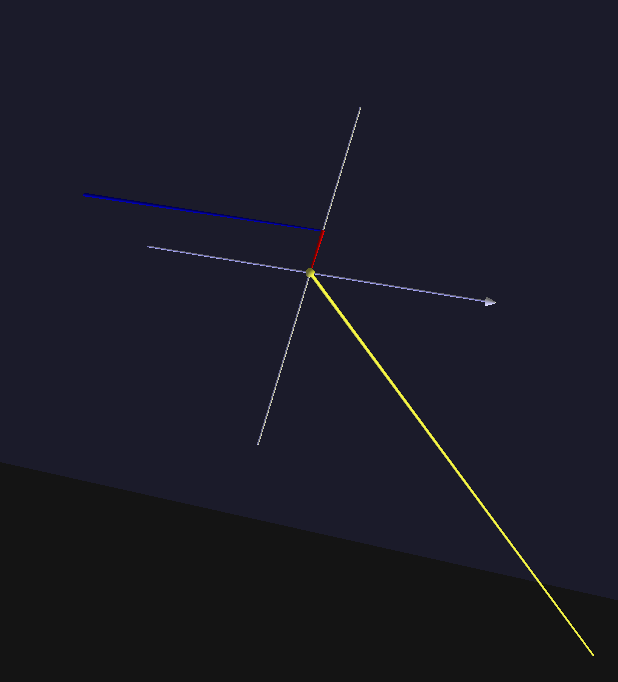

In [17]:
display(Image(filename="Images/tool_rotary_assembly_inside.png",
              height=300, width=300))

To be able to add these (y,z)-pivot values to our kinematic model we need to create a transformation matrix that has the effect of a translation. 
Note that the direction chosen for these offsets is important here as our translation is basically a vector and we have chosen that this 'pivot-length' vector points from the spindle nose to the pivot-point. Since we are building the forward kinematic model we are travelling against this vector and thus its components ($L_y,L_z$) need to be entered in the negative.

In [18]:
# define translation matrix for the pivot length
var('Lz')
Tl=matrix([[ 1, 0, 0, 0],
           [ 0, 1, 0, 0],
           [ 0, 0, 1, -Lz],
           [ 0, 0, 0, 1 ]])
display(Math(rf'T_l =~'+latex(Tl)))

Tnl=matrix([[ 1, 0, 0, 0],
            [ 0, 1, 0, 0],
            [ 0, 0, 1, Lz],
            [ 0, 0, 0, 1 ]])
display(Math(rf'T_nl =~'+latex(Tnl)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [19]:
#define translation matrix for offsets
var('Dx')
Td=matrix([[ 1, 0, 0, -Dx],
           [ 0, 1, 0,  0 ],
           [ 0, 0, 1,  0 ],
           [ 0, 0, 0,  1 ]])
display(Math(rf'T_d =~'+latex(Td)))

Tnd=matrix([[ 1, 0, 0, Dx],
           [ 0, 1, 0,  0 ],
           [ 0, 0, 1,  0 ],
           [ 0, 0, 0,  1 ]])
display(Math(rf'T_nd =~'+latex(Tnd)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Tool length offset (TLO)

As we could see above in our inspection of the spindle rotary assembly the tool length offset ($Dt$) has the same direction as the z-component of the pivot-offset ($Lz$) that is, a positive $Dt$ value points in the negative machine-z direction.
So as a building block in our forward kinematic transformation the value of $Dt$ needs to be in the negative:

In [20]:
# define translation matrix for the tool length
var('Dtx','Dty','Dtz')
Tt=matrix([[ 1, 0, 0, -Dtx ],
           [ 0, 1, 0, -Dty ],
           [ 0, 0, 1, -Dtz ],
           [ 0, 0, 0, 1 ]])
display(Math(rf'T_t =~'+latex(Tt))) 

Tnt=matrix([[ 1, 0, 0, Dtx],
            [ 0, 1, 0, Dty],
            [ 0, 0, 1, Dtz],
            [ 0, 0, 0, 1 ]])
display(Math(rf'T_nt =~'+latex(Tnt)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>


## Tool spindle angle


In [21]:
# define rotation matrix for tool-spindle rotation (ie rotation around z-axis)
var('Ctc','Stc')
Rtc=matrix([[ Ctc, -Stc,   0, 0],
           [ Stc,  Ctc,   0, 0],
           [ 0 ,  0 ,   1, 0],
           [ 0,   0 ,   0, 1]])
display(Math(rf'R_tc =~'+latex(Rtc)))

<IPython.core.display.Math object>

In [22]:
#define forward translation matrices
Tc=matrix([[ 1, 0, 0, (Dtx+Dx)],
           [ 0, 1, 0,  Dty],
           [ 0, 0, 1, (Dtz+Lz)],
           [ 0, 0, 0,      1 ]])
display(Math(rf'T_c =~'+latex(Tc)))

Tnc=matrix([[ 1, 0, 0, -(Dtx+Dx)],
            [ 0, 1, 0, -Dty],
            [ 0, 0, 1, -(Dtz+Lz)],
            [ 0, 0, 0, 1 ]])
display(Math(rf'T_nc =~'+latex(Tnc)))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
# calculate the forward transformation matrix
# note: the brackets *(Tl*Tt) are only used to get a cosmetically
# prettier result since it seems to keep "(Dt+Lz)"
# similar for (Tp*Tr)
#qAp=Tnr*Tc*Rw*(Tp*Tr)*Rt*Td*(Tl*Tt)
display(Math(rf'T_c =~'+latex(Tc)))
qAp=Tc*Rw*Tp*Rt*Td*Rtc*(Tl*Tt)
display(Math(rf'^Q A_P =~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note that this is a translation of the result of our forward transformation matrix $^QA_P$ it needs to be multiplied from the left:

$$^QA_P = T_c \cdot R_w \cdot T_p \cdot R_t \cdot T_d \cdot R_tc \cdot T_l \cdot T_t$$

In [24]:
# calculate the forward transformation matrix
# note: the brackets *(Tl*Tt) are only used to get a cosmetically
# prettier result since it seems to keep "(Dt+Lz)"
# similar for (Tp*Tr)
#qAp=Tnr*Tc*Rw*(Tp*Tr)*Rt*Td*(Tl*Tt)
display(Math(rf'T_c =~'+latex(Tc)))
qAp=Tc*Rw*Tp*Rt*Td*Rtc*(Tl*Tt)
display(Math(rf'^Q A_P =~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
Qx=qAp[0][3]
Qy=qAp[1][3]
Qz=qAp[2][3]

display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Qx)))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Qy)))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Qz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [26]:
# expressions as used in xyzabc_trsrn.comp
print('TCP kinematics FORWARD')
print('Qx = ', Qx,';')
print('Qy = ', Qy,';')
print('Qz = ', Qz,';')

TCP kinematics FORWARD
Qx =  -Ct*Cw*Dx - Cw*(Dtz + Lz)*St - (Ct*Ctc*Cw - Stc*Sw)*Dtx + (Ct*Cw*Stc + Ctc*Sw)*Dty + Cw*Px - Py*Sw + Dtx + Dx ;
Qy =  -Ct*Dx*Sw - (Dtz + Lz)*St*Sw - (Ct*Ctc*Sw + Cw*Stc)*Dtx + (Ct*Stc*Sw - Ctc*Cw)*Dty + Cw*Py + Px*Sw + Dty ;
Qz =  Ctc*Dtx*St - Dty*St*Stc - Ct*(Dtz + Lz) + Dx*St + Dtz + Lz + Pz ;


### Inverse transformation

To calculate the joint position $P$ from a given coordinate position $Q$ we need to follow the kinematic chain in the opposite direction from the spindle to work piece. We can invert our forward kinematic transformation and build it backwards, using the inverted rotations and the inverted translations.<br>
Note that the input matrix $T_p$ with its translation {$T_p \cdot T_r$} for the offset of the rotation axis and the output translation $[T_{-r} \cdot T_c]$ need to be handled with some consideration: 

$$^QA_P = [T_{-r} \cdot T_c] \cdot R_w \cdot \{T_p \cdot T_r\} \cdot (R_t \cdot T_d \cdot R_tc \cdot T_l \cdot T_t)$$
$$^QA_P = [offset_{fo}] \cdot R_w \cdot \{input+offset_{fi}\} \cdot (R_t \cdot T_d \cdot R_tc \cdot T_l \cdot T_t)$$



In the inverse transformation the input is $T_q$ and it's 'offset' is the inverse of the 'output offset' of the forward transformation.
Basically what we added to the result of the forward transformation needs to be removed from the input to the inverse transformation and vice versa. On the right side we additionally need to rotate the inverted spindle offsets by the rotation of the rotary C:

$$^QA_P = [-offset_{fi}] \cdot R^T_w \cdot \{input-offset_{fo}\} \cdot (R_w \cdot R_t \cdot T_{-d} \cdot R_tc \cdot T_{-l} \cdot T_{-t})$$


$$^PA_Q = \{ T_{-r}\} \cdot R^T_w \cdot T_q \cdot [T_{r} \cdot T_{-c}]  \cdot(R_w \cdot R_t \cdot T_{-d} \cdot R_tc \cdot T_{-l} \cdot T_{-t})$$

Note that the brackets in the above expressions are only used to highlight the different parts of the kinematic model and are not mathematically required. 

This being the inverse transformation our input matrix has changed to $T_q$:



In [27]:
# define coordinate position matrix
var('Qx','Qy','Qz')
Tq=matrix([[ 1, 0, 0, Qx ],
           [ 0, 1, 0, Qy],
           [ 0, 0, 1, Qz],
           [ 0, 0, 0, 1 ]])
display(Math(rf'T_q =~'+latex(Tq)))

<IPython.core.display.Math object>

In [28]:
#qAp=Tc*Rw*Tp*Rt*Td*Rtc*(Tl*Tt)
pAq=Rw.transpose()*(Tq*Tnc)*Rw*Rt*Tnd*Rtc*Tnl*Tnt

In [29]:
display(Math(latex(Tq)+rf'\cdot'+latex(Rt.transpose())+rf'\cdot'+latex(Tnt)))
display(Math(rf'^PA_Q=~'+latex(pAq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [30]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
Px=pAq[0][3]
Py=pAq[1][3]
Pz=pAq[2][3]

display(Math(latex(P_[0][0]) + rf'~=~'  + latex(Px)))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(Py)))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(Pz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note that $$cos²\theta+sin²\theta=1$$

In [32]:
Px=Px.subs({(Cw^2 + Sw^2):1})
Py=Py.subs({(Cw^2 + Sw^2):1})
Pz=Pz.subs({(Cw^2 + Sw^2):1})
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(Px)))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(Py)))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(Pz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [45]:
# expressions as used in the kinematics .comp
print(' MILL -- TCP kinematics INVERSE')
print('Px = ', Px,';')
print('Py = ', Py,';')
print('Pz = ', Pz,';')

 MILL -- TCP kinematics INVERSE
Px =  Cw*Lz*St + Cw*Qz*St - Cw*Dx + (Ct*Ctc*Cw - Stc*Sw)*Qx - (Ct*Cw*Stc + Ctc*Sw)*Qy ;
Py =  Lz*St*Sw + Qz*St*Sw + (Ct*Ctc*Sw + Cw*Stc)*Qx - (Ct*Stc*Sw - Ctc*Cw)*Qy - Dx*Sw ;
Pz =  -Ctc*Qx*St + Qy*St*Stc + Ct*Lz + Ct*Qz - Lz ;


Also note that with this kinematic model the offset of the rotational axis of the rotary C is the vector $(Dra_x,Dra_y,0)$ going from the pivot-point of the spindle assembly to the rotatio-axis of C with the machine in the home position.
In other words if the C-rotary-axis has the absolute machine coordinates $(Rot_x,Rot_y,0)$ then $$Dra_x = Rot_x - Dx$$ $$Dra_y = Rot_y - Ly$$

In the kinematic comp this is handled in the variable declaration:

    // geometric offsets of the universal spindle head as defined in 
    double         Ly = *haldata->y_pivot;
    double         Lz = *haldata->z_pivot;
    double         Dx = *haldata->x_offset;
    double         Dz = *haldata->z_offset;
    double       Drax = *haldata->x_rot_axis - Dx;
    double       Dray = *haldata->y_rot_axis - Ly;

This concludes the TCP kinematic


-----

# Tool Kinematic model
Many, if not most, applications for 5-axis milling do not require TCP kinematics where all five axes are moving simultaneously but only need the work piece to be oriented at certain angles to the tool in between 'conventional' three axis (x,y,z) milling operations. In these operations the tool is not reoriented while cutting the material. This is what is called '3+2' mode.<br>
In 3+2 mode the machine operator can use the familiar built in cycles the machine controller offers for 3d (x,y,z) use and does not necessarily require CAM/CAD software to machine a part. The ability to move the tool in a plane perpendicular to its rotational axis also allows the use of probes for job setup.<br>
Machines with work side rotation (eg the C rotary in our example, or the 'table-rotary-tilting' examples included in LinuxCNC simulation configs) can orient the work piece to the tool by simply rotating the work to the required orientation as the tool always remains oriented along the machine z-axis. A drilling operation on such a machine will thus still only require the machine z-axis to be moved no matter how the part is oriented.  In this case no special kinematic is required.<br>
Machines with tool side rotation like the one presented here with A and B spindle rotations however retain the directions of the unrotated machine coordinate system when moving in IDENTITY and TCP kinematics while the tool orientation changes in respect to the machine coordinate system.  A drilling operation on such a machine will require the machine to move in a complex manner that may include all three (x,y,z) axes depending on how tool is oriented.<br>
Commercial 5-axis machine controllers offer built in functionality that allow the operator to define work plane orientation using Gcode commands like G68.2 or similar; automatically adjusting the kinematic model to the type of kinematic of the machine. To implement such a feature for our example machine using LinuxCNC we need to create another kind of kinematic model which we will call the TOOL kinematic.  



### Forward transformation

For the TOOL kinematic start at the tool tip and work towards the work piece omitting the C axis rotation. So in our example case our forward transformation matrix $^QA_P$ is :

$$^QA_P = R^T_{tc} \cdot T_l \cdot R^T_a \cdot T_d \cdot R^T_b\ \cdot ( T_p \cdot T_{-d} \cdot T_{-l})$$

Where $R_{tc}$ is a virtual rotation around the rotational axis of the tool. This is required because we need a way to define the orientation of the tool-x (and -y). Without this the tool-coordinate system will be 'fixed' to the spindle head orientation which we do certainly want for the tool-z orientation but not for the x,y-directions. This will be important when developing the 'Tilted Work Plane' features later.

Tool-length offset is applied automatically in LinuxCNC by subtracting the tool length value stored in the tool table from the z-axis coordinate position while the joint position remains unchanged. This built in compensation also work in our custom tool kinematic because the tool coordinate system is always aligned with the rotational axis of the tool.

Note that the brackets in the above expressions are only used to highlight the different parts of the kinematic model and are not mathematically required. 

In [33]:
# add c rotation of tool coordinate system
var('Ctc','Stc')
Rtc=matrix([[ Ctc, -Stc,   0, 0],
           [ Stc,  Ctc,   0, 0],
           [ 0 ,  0 ,   1, 0],
           [ 0,   0 ,   0, 1]])

In [34]:
# calculate the forward kinematic 
# brackets are only used for cosmetically adjust the resulting formula
#qAp=Rtc.transpose()*(Tl)*Ra.transpose()*Td*Rb.transpose()*(Tp*Tnd*Tnl)   
qAp=Rtc.transpose()*(Tl)*Td*Rt.transpose()*(Tp*Tnl)*Rw.transpose()                                                              
display(Math(rf'^Q A_P =~'+latex(qAp)))


<IPython.core.display.Math object>

In [35]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
Qx=qAp[0][3]
Qy=qAp[1][3]
Qz=qAp[2][3]

display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Qx)))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Qy)))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Qz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [36]:
# expressions as used in xyzabc_trsrn.comp
print('TOOL kinematics FORWARD')
print('pos->tran.x = ', Qx, ';')
print('pos->tran.y = ', Qy, ';')
print('pos->tran.z = ', Qz, ';')

TOOL kinematics FORWARD
pos->tran.x =  Ct*Ctc*Px - Ctc*(Lz + Pz)*St - Ctc*Dx + Py*Stc ;
pos->tran.y =  -Ct*Px*Stc + (Lz + Pz)*St*Stc + Ctc*Py + Dx*Stc ;
pos->tran.z =  Ct*(Lz + Pz) + Px*St - Lz ;


### Inverse transformation

For the inverse kinematic we need to move from the machine coordinates to the tool coordinates starting with the inverted offset translations $(T_d \cdot T_l )$ for the offsets we used on the input of the forward kinematic $T_{-d} \cdot T_{-l}$:

$$^QA_P = R^T_{tc} \cdot T_l \cdot R^T_a \cdot T_d \cdot R^T_b\ \cdot ( T_p \cdot T_{-d} \cdot T_{-l})$$

$$^PA_Q = (T_d \cdot T_l ) \cdot R_b \cdot T_{-d} \cdot R_a \cdot T_{-l} \cdot R_{tc}\cdot T_q $$

Note that the brackets in the above expressions are only used to highlight the different parts of the kinematic model and are not mathematically required.  

In [37]:
# calculate the inverse kinematic 
# brackets are only used for cosmetically adjust the resulting formula
#qAp=Rtc.transpose()*(Tnl)*Ra.transpose()*Tnd*Rb.transpose()*(Tp*Td*Tl)                                                     
#pAq=(Td*Tl)*Rb*Tnd*Ra*Tnl*Rtc*Tq
#qAp=Rtc.transpose()*(Tl)*Rt.transpose()*(Tp*Tnl)     
pAq=(Td*Tl)*Rt*Tnd*Tnl*Rtc*Tq

display(Math(rf'^PA_Q =~'+latex(pAq)))

<IPython.core.display.Math object>

In [38]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
Px=pAq[0][3]
Py=pAq[1][3]
Pz=pAq[2][3]

display(Math(latex(P_[0][0]) + rf'~=~'  + latex(Px)))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(Py)))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(Pz)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [39]:
# expressions as used in xyzabc_trsrn.comp
print('TOOL kinematics INVERSE')
print('Px = ', Px, ';')
print('Py = ', Py, ';')
print('Pz = ', Pz, ';')

TOOL kinematics INVERSE
Px =  Ct*Ctc*Qx - Ct*Qy*Stc + Ct*Dx + Lz*St + Qz*St - Dx ;
Py =  Ctc*Qy + Qx*Stc ;
Pz =  -Ctc*Qx*St + Qy*St*Stc + Ct*Lz + Ct*Qz - Dx*St - Lz ;


This completes the TOOL kinematic and we can move on to our implementation of the 'Tilted Work Plane' feature


In [40]:
# calculate the inverse kinematic 
# brackets are only used for cosmetically adjust the resulting formula
#qAp=Rtc.transpose()*(Tnl)*Ra.transpose()*Tnd*Rb.transpose()*(Tp*Td*Tl)                                                     
#pAq=(Td*Tl)*Rb*Tnd*Ra*Tnl*Rtc*Tq
#qAp=Rtc.transpose()*(Tl)*Rt.transpose()*(Tp*Tnl)     
pAq=Rw*(Td*Tl)*Rt*Tnl*Rtc*Tq

display(Math(rf'^PA_Q =~'+latex(pAq)))

<IPython.core.display.Math object>

In [41]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
Px=pAq[0][3]
Py=pAq[1][3]
Pz=pAq[2][3]

display(Math(latex(P_[0][0]) + rf'~=~'  + latex(Px)))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(Py)))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(Pz)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [42]:
# expressions as used in xyzabc_trsrn.comp
print('TOOL kinematics INVERSE')
print('Px = ', Px, ';')
print('Py = ', Py, ';')
print('Pz = ', Pz, ';')

TOOL kinematics INVERSE
Px =  Cw*Lz*St + Cw*Qz*St - Cw*Dx + (Ct*Ctc*Cw - Stc*Sw)*Qx - (Ct*Cw*Stc + Ctc*Sw)*Qy ;
Py =  Lz*St*Sw + Qz*St*Sw + (Ct*Ctc*Sw + Cw*Stc)*Qx - (Ct*Stc*Sw - Ctc*Cw)*Qy - Dx*Sw ;
Pz =  -Ctc*Qx*St + Qy*St*Stc + Ct*Lz + Ct*Qz - Lz ;


-----

# 'Tilted Work Plane' (TWP)

Commercial 5-axis machine controllers offer built in functionality that allow the operator to define work plane orientation using Gcode commands like G68.2 or similar. With the new custom TOOL kinematic we can now explore a possible implementation of TWP in LinuxCNC.<br>
For the purpose of this example we choose the already mentioned 'G68.2' and the associated Gcodes as used by Fanuc:<br>

* G68.2 - Set custom coordinate system using five different modes
* G68.3 - Set custom coordinate system using current tool orientation
* G68.4 - Same as 68.2 but as an incremental reorientation of an existing TWP

* G53.1 - Orient the tool to the TWP using non-TCP joint rotation 
* G53.6 - Orient the tool to the TWP using TCP joint rotation

* G69 - Cancel the TWP setting

The TWP feature always requires a TWP-definition (G68.x) before an orientation command (G53.x) can be issued.<br> 
G68.x commands do not cause any machine movement while G53 command will cause immediate machine movement.
At the end of a TWP operation a G69 command is used to return to machine coordinates.<br>

In this presentation we use a 'Pure Python Remap' to make the above Gcode commands available to the machine operator. As a consequence our depth of integration is quite limited in the sense that the LinuxCNC Gcode interpreter will be totally ignorant of our 'TWP'-mode.

### Implementation outline

This should give a rough overview of how TWP functionality is to be achieved with a python remap:


The idea of TWP is to give the machine operator a mechanism to define a virtual work plane that is rotated (and optionally offset) in respect to the machine coordinate system. As mentioned above this is fairly trivial in a machine with work side rotation as its tool spindle is fixed to be aligned with the machine z-axis. In such a machine the tool coordinate system (TCS) remains in the orientation of the machine coordinate system (MCS)<br>
In a machine with tool side rotation however the TCS rotates in respect to the MCS as the rotary joints move. The orientation of the TCS for a given joint rotation can be calculated using the rotational part of the transformation matrix as derived above. Furthermore we can also solve for the inverse case of finding the joint positions that will orient the tool to a given orientation.
Note here that this is very much dependent on the specific kinematic of the machine at hand and will require careful analysis of the kinematic model to find any ambiguities in the solution as some specific tool orientations might be achieved in multiple joint positions. 

So to define the TWP means to define a target TCS in respect to the MCS and for this the use of a transformation matrix is well suited as it contains the rotation as well as the (optional) translation. 


### Step 1: Definition of the TWP
The TWP is defined by a rotation (I,J,K) and optional offset (X,Y,Z) of the TCS in respect to the MCS. The optional offset is calulated from the current work offset position at the time when the G68.2 or G68.3 command is issued. 

The operator can choose from different methods to define the rotation of the custom work plane:

*  G68.2 ... P0 ... - 'True Euler'-angles (this is the default if the P word is omitted)

*  G68.2 ...  P1 ... - 'Pitch-Roll-Yaw'-angles

*  G68.2 ...  P2 ... - 3 points in the plane (3 points define two vectors)

*  G68.2 ...  P3 ... - 2 vectors (tool-x and tool-z)

*  G68.2 ...  P4 ... - projected angles (A around machine-x, B around machine-y)

For the above methods we create the transformation matrix either by using euler-rotations of the 4x4 identity matrix or by the vector information passed by the command using the cross product to calculate the y-vector. For the projected angles we use basich trigonometry to calculate the vector components.
These calculations are independent from the specific machine kinematics.

*  G68.3 ...... - define TWP perpendicular to the current tool orientation 

Here we need to use the specific machine kinematic model to calculate the transformation matrix of the current TCS. 

*  G68.4 ...... - same as G68.2 but relative to the current TWP

Here we need to multiply the current TWP transformation matrix with the one built from the command words.

*  G69 - cancel TWP

Here we reset the TWP transformation matrix to the 4x4 identity matrix (ie no rotation, no translation).

Note that, contrary to some other controllers, moves commanded between G68.x and G53.x will be in the MCS.

### Step 2: Orientation of the tool to the TWP
Once the TWP has been defined the machine spindle can be oriented by moving the rotary joints to the appropriate positions.  

The operator can choose whether the rotation is done in IDENTITY kinematics (only the rotary joints move) or in TCP kinematics where all joint may move to keep the tool center point in position:

*  G53.1 - orient the tool to the TWP without using TCP

*  G53.6 - orient the tool to the TWP with using TCP

### Handling work offsets when switching to TWP
The TWP is defined relative to the work offset (eg G54) active when issuing a G62.x command. With the execution of the following G53.x command and the reorientation of the spindle the kinematic is switched to the TOOL kinematics and the coordinate position in the DRO will then reflect the coordinate position in the rotated TCS. If the work offset values were to be used without adjusting for the kinematic switch then the physical position of the work offset would be rotated out of place and the reference to the work coordinate system (WCS) would be lost. So in order to find the reference on the work piece in the TCS we need to use the TWP transformation matrix to transform the work offset values set in WCS to the new TCS.<br>
Note that the original work offset will have to be restored when the TWP is canceled with a G69 command.<br>

### Caveats of TOOL kinematics (TOOL kinematics is NOT TCP!)
Any machine operator using TOOL kinematics should be well aware of its behavior before issuing motion commands!<br>
It must be stressed that, while TOOL kinematics are active, any movement of a rotary joint will cause the machine to rotate the TCS  around the machine reference point. Because the magnitude of the resulting movement increases with the distance between the tool position and the machine reference point the effect may seem unpreditable to the inexperienced operator.
Note here that it is possible to set the rotation point in TOOL kinematics in much the same way as we offset the rotation-point from machine zero in TCP kinematics. This however would further complicate work offset transformation and there seems to be no immediate benefit to it. 


## Calculating the spindle rotary joint positions for a given tool-orientation vector


The transformation matrix we derived for the inverse tool kinematic contains a rotation matrix that describes the rotation of the unit vectors of the machine coordinate system (MCS)


\begin{equation}
U ~=~
\left(\begin{array}{rrrr}
  1, 0, 0 \\
  0, 1, 0 \\
  0, 0, 1 \\
\end{array}\right)
~
Unitvectors~of~the~MCS
\end{equation}

to the tool coordinate system (TCS).


\begin{equation}
K ~=~
\left(\begin{array}{rrrr}
  Kx_x, Ky_x, Kz_x \\
  Kx_y, Ky_y, Kz_y \\
  Kx_z, Ky_z, Kz_z \\
\end{array}\right)
~
Toolvector
\end{equation}

To orient the tool perpendicular to the TWP requested by the user we need to find the angles of the spindle rotary joints so that the resulting tool-z vector matches the twp-z vector.

First we extract the tool-z vector from the third column of the transformation matrix in the inverse tool kinematic

In [43]:
# Tool-z orientation vector K 
var('Kz_x','Kz_y','Kz_z')
Kz_=matrix([[Kz_x],
          [Kz_y],
          [Kz_z],
          [1]])
# Tool-x orientation vector J 
var('Kx_x','Kx_y','Kx_z')
Kx_=matrix([[Kx_x],
          [Kx_y],
          [Kx_z],
          [1]])

In [44]:
# Extract the tool-z orientation vector from
# the third column of the inverse transformation matrix
Kx=pAq[0][2]
Ky=pAq[1][2]
Kz=pAq[2][2]

display(Math(latex(Kz_[0][0]) + rf'~=~'  + latex(Kx)))
display(Math(latex(Kz_[1][0]) + rf'~=~'  + latex(Ky)))
display(Math(latex(Kz_[2][0]) + rf'~=~'  + latex(Kz)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Calculating the tool spindle angle $\theta_t$
$$ Kz_z ~=~ C_t $$

$$ \theta_T ~=~\pm acos({Kz_z}) $$



### Calculating the table angle $\theta_w$
$$ Kz_x =  C_wS_t  $$

$$ \theta_w = \pm acos({Kz_x \over S_t}),~S_t \neq 0$$



Handling the case of  ${\theta_{t}} = 0°$:

If the spindle angle is 0° the tool is vertical and thus parallel to the table rotary axis. In this case there are infinite results for $\theta_w$ so we set $\theta_w = 0$